<a href="https://colab.research.google.com/github/francobarrionuevoenv21/codeforenviroprojects/blob/testGEE/test01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap

In [58]:
import geemap
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=d9rFd0SMEzuIOh88EpJS-xgaLmA86oxvHuCa-iF5uUY&tc=M5_UMwDU8Mu34onwLQoVtaJRFW62X8bekzl5uwcknds&cc=J_RLvtOSp8IPsPGtrBQY8UveSjN22jZMGRJPKCY0whU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BWN5YkJIWtQll-XHVTTz8xcbwz4ITvM3cVkXKv4JA9hqCECCfuG0Sw

Successfully saved authorization token.


In [37]:
# Code to read csv file into Colaboratory:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Functions

In [38]:
def getCoordsSHP(gdfshpFile):
  '''
  This function takes a polygon vector layer file passed as a GeoDataFrame. Then
  it gets all longitude and latitude values and return it as numpy arrays.
  '''

  gdfiterf = gdfshpFile.iterfeatures()
  tupleFile = next(gdfiterf)['geometry']['coordinates']

  #arrayCoords = np.array([list(tupleFile[0][i]) for i in range(len(tupleFile[0]))])

  return tupleFile

def FileDataDf(dictFiles, i, source):

  if source == 'gdrive': # Files hosted in Google Drive.
    FilesPath = list(dictFiles.values())[i]
    idPath = FilesPath.split('/', 6)
    downloadedFiles = drive.CreateFile({'id':idPath[5]})
    downloadedFiles.GetContentFile(list(dictFiles.keys())[i])
    dfData = pd.read_csv(list(dictFiles.keys())[i])

  elif source == 'other': # Files imported from device or Colab files
    dfData = pd.read_csv(list(dictFiles.values())[i])

  return dfData

In [45]:
StudyArea = gpd.read_file('/content/reg_ftales_2019_3857b.shp')
target_crs = "EPSG:4326"
StudyArea = StudyArea.to_crs(target_crs)

In [62]:
StudyArea

,region,geometry
0,Bosque Andino Patagónico,"MULTIPOLYGON (((-66.54755 -55.06351, -66.54783..."
1,Delta e Islas del Río Paraná,"MULTIPOLYGON (((-58.61195 -27.31685, -58.61359..."
2,Espinal,"MULTIPOLYGON (((-62.23475 -39.33826, -62.23352..."
3,Monte,"MULTIPOLYGON (((-66.14624 -24.82198, -66.14220..."
4,Parque Chaqueño,"MULTIPOLYGON (((-57.22151 -27.46420, -57.22144..."
5,Selva Paranaense,"MULTIPOLYGON (((-56.86162 -27.59213, -56.86047..."
6,Yungas,"MULTIPOLYGON (((-65.61922 -25.56052, -65.61847..."


In [65]:
listRegions = list(StudyArea.region.values)
listProvsColor = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']

In [72]:
type(listRegions[0])

str

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for idx, l in enumerate(listRegions):
  StudyArea[StudyArea['region']==l].plot(ax=ax, color=listProvsColor[idx], label=listRegions[idx])

fig.legend(fontsize =10)

plt.show()

<Axes: >

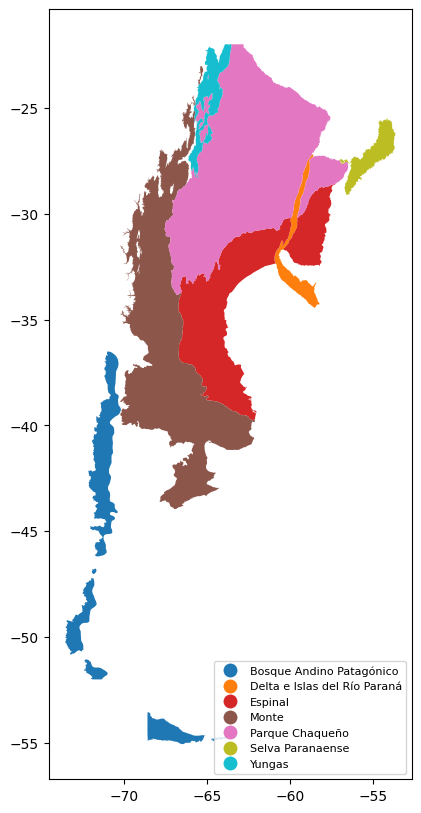

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
StudyArea.plot(ax=ax, column='region', categorical=True, legend=True, legend_kwds={'loc': 'lower right', 'fontsize': 8})


In [ ]:
# Sample tuple of tuples
tuple_of_tuples = getCoordsSHP(StudyArea)[0]

# Convert to a list of lists with only the first 2 elements
list_of_lists = [list(t[:2]) for t in tuple_of_tuples]

In [ ]:
coordinates = list_of_lists

# Create an ee.Geometry.Polygon object
polygon = ee.Geometry.Polygon(coordinates)

# Create a feature from the polygon
feature = ee.Feature(polygon)

# Create a feature collection from the feature
feature_collection = ee.FeatureCollection([feature])

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
stylePoly = {'color': '000000ff', 'width': 2, 'fillColor': '00000000'}
Map.addLayer(feature_collection.style(**stylePoly), {}, "Delta")
Map.centerObject(feature_collection, 7)

In [ ]:
#https://developers.google.com/earth-engine/apidocs/ee-featurecollection-style

In [ ]:
dictFilesPath ={
    "1.csv" : "https://drive.google.com/file/d/1YdDj72tl-rnQpzIaZSyd6see2aoPMewg/view?usp=share_link",
    }

dfHSArgDelta = FileDataDf(dictFilesPath, 0, source = 'gdrive')

gdfHSArgDelta = gpd.GeoDataFrame(
    dfHSArgDelta,
    geometry=gpd.points_from_xy(dfHSArgDelta['longitude'], dfHSArgDelta['latitude']),
    crs='epsg:4326')

In [ ]:
points = gdfHSArgDelta.head(50)[['longitude', 'latitude']].values.tolist()

listOfFeatures = [ee.Geometry.Point(point) for point in points]

listOfFeaturesFc = ee.FeatureCollection(listOfFeatures)

stylePoints = {'color': 'red', 'pointSize' : 5, 'pointShape' : 'diamond'}
Map.addLayer(listOfFeaturesFc.style(**stylePoints), {}, "Points")

In [ ]:
# Draw a polygon on the map
polygondrawn = Map.draw_last_feature

# Get the coordinates of the polygon
polygondrawn.geometry().getInfo()['coordinates']

[[[-58.750037, -34.106688],
  [-58.733556, -34.147044],
  [-58.671753, -34.158409],
  [-58.650465, -34.142498],
  [-58.657332, -34.122037],
  [-58.721195, -34.102708],
  [-58.750037, -34.106688]]]

De aca para abajo adsadsad

In [ ]:
# allow images to display in the notebook
from IPython.display import Image

In [ ]:
roi_coordinates = polygondrawn.geometry().getInfo()['coordinates']

# Create the ROI as an ee.Geometry.Polygon
roi = ee.Geometry.Polygon(roi_coordinates)

# Landsat-8 takes 8 days to come back to the same place

# Start date of the range to filter for
start_date = '2020-01-01'

# End date
end_date = '2020-09-10'

# Get the satellite data
Landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi).filterDate(start_date, end_date)

# put the images in a list
landsat_list = Landsat8.toList(Landsat8.size())

In [ ]:
type(landsat_list.get(0))

ee.computedobject.ComputedObject

In [ ]:
listIdxCloud = []

for i in range(Landsat8.size().getInfo()):

    # when was this image taken?
    date = ee.Image(landsat_list.get(i)).get('DATE_ACQUIRED').getInfo()
    # cloud cover
    cloud = ee.Image(landsat_list.get(i)).get('CLOUD_COVER').getInfo()

    if cloud < 20:
      listIdxCloud.append(i)

    print(date, cloud)

2020-01-02 63.99
2020-01-18 20.71
2020-02-03 0.81
2020-02-19 2.44
2020-03-06 82.5
2020-03-22 4.93
2020-04-07 2.87
2020-04-23 88.05
2020-05-09 13.37
2020-05-25 42.41
2020-06-10 11.07
2020-06-26 10.7
2020-07-12 78.59
2020-07-28 1.61
2020-08-13 1.81


In [ ]:
listIdxCloud

[2, 3, 5, 6, 8, 10, 11, 13, 14]

In [ ]:
landsat_list

In [ ]:

parameters = {
                'min': 7000,
                'max': 16000,
                'dimensions': 600, # square size in pixels
                'bands': ['SR_B6', 'SR_B5', 'SR_B4'] # bands to display (r,g,b)
             }

display(Image(url = ee.Image(landsat_list.get(8)).getThumbUrl(parameters)))

In [ ]:
#Landsat8.size()
#print(landsat_list)

In [ ]:
print(ee.Image(landsat_list.get(1)).bandNames().getInfo())

print(ee.Image(landsat_list.get(1)).select('SR_B1').projection().getInfo())

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
{'type': 'Projection', 'crs': 'EPSG:32621', 'transform': [30, 0, 227385, 0, -30, -3715485]}


In [ ]:
geom_clip = polygondrawn.geometry()

In [ ]:
geom_clip

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          -58.750037,
                          -34.106688
                        ],
                        [
                          -58.733556,
                          -34.147044
                        ],
                        [
                          -58.671753,
                          -34.158409
                        ],
                        [
                          -58.650465,
                          -34.142498
                        ],
                        [
                          -58.657332,
                          -34.122037
                        ],
                        [
                          -58.721195,
                          -34.102708
                        ],
                        [
                          -58.750037,
                          -34.106688
                        ]
                      ]
                    ]
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [ ]:
#ee.Image(landsat_list.get(1)).clip(geometry)

display(Image(url = ee.Image(landsat_list.get(5)).clip(geom_clip).getThumbUrl(parameters)))

Export image

References:
https://eamena.org/sites/default/files/eamena/documents/media/gis_4_-_introduction_to_gee_and_sentinel-2_imagery-compressed.pdf
https://gis.stackexchange.com/questions/300344/exported-bands-must-have-compatible-data-types-found-inconsistent-types-uint16
https://gis.stackexchange.com/questions/347340/export-google-earth-engine-landsat-image-to-google-drive-not-working-in-python-a

In [ ]:
select_bands = ee.Image(landsat_list.get(1)).bandNames().getInfo()[0:6]
select_bands

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']

In [ ]:
image_bands = ee.Image(landsat_list.get(1)).select(select_bands)

In [ ]:
image_bands

In [ ]:
export_task = ee.batch.Export.image.toDrive(
    image = image_bands,
    region = geom_clip,
    #description = 'test01'
)

In [ ]:
export_task.start()

In [ ]:
export_task.status()

{'state': 'READY',
 'description': 'myExportImageTask',
 'creation_timestamp_ms': 1672542935978,
 'update_timestamp_ms': 1672542935978,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'SOGVC6ZNDRHMGGGMWYYPFWHM',
 'name': 'projects/earthengine-legacy/operations/SOGVC6ZNDRHMGGGMWYYPFWHM'}